# FRIENDS Datasets Analysis, Parsing, and Preprocessing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
# script and IMDB ratings imports
df_script = pd.read_csv("friends_all_episodes_clean.csv")
df_rating = pd.read_csv("friends_episodes_v3.csv", encoding='latin-1')

---

## Script Dataset Preprocessing

Checking per column what attributes are available or can be derived. Also checking what preprocessing is needed and implementing it. The dataset is from Kaggle, made by users Bree Nguyen and Blesson Densil, accessible [here](https://www.kaggle.com/datasets/brzy56/friends-tv-television-scripts-all-dialogue-csv).

The column names and descriptions are:
- `episode_number` — Episode code (e.g., `S01E01`)
- `title` — Episode title
- `writers` — Writer(s) of the episode
- `type` — Classification: dialogue, stage_direction, scene_note, content
- `speaker` — Character speaking (blank if not dialogue)
- `dialogue_raw` — Original dialogue text (includes inline notes)
- `dialogue_clean` — Dialogue text with inline notes removed
- `stage_direction_inline` — Inline parentheses content within dialogue
- `scene_note_inline` — Inline bracket content within dialogue
- `stage_direction_only` — For standalone stage direction lines
- `scene_note_only` — For standalone scene note lines
- `content` — Non‑dialogue text/content lines
- `season` — Season number
- `episode` — Episode number

In [3]:
df_script.head(5)

,episode_number,title,writers,type,speaker,dialogue_raw,dialogue_clean,stage_direction_inline,scene_note_inline,stage_direction_only,scene_note_only,content,season,episode
0,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,scene_note,NaN,NaN,NaN,NaN,NaN,NaN,"Scene: Central Perk, Chandler, Joey, Phoebe, a...",NaN,1.0,1.0
1,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,dialogue,Monica,There's nothing to tell! He's just some guy I ...,There's nothing to tell! He's just some guy I ...,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,dialogue,Joey,"C'mon, you're going out with the guy! There's ...","C'mon, you're going out with the guy! There's ...",NaN,NaN,NaN,NaN,NaN,1.0,1.0
3,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,dialogue,Chandler,"All right Joey, be nice. So does he have a hu...","All right Joey, be nice. So does he have a hu...",NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,dialogue,Phoebe,"Wait, does he eat chalk?","Wait, does he eat chalk?",NaN,NaN,NaN,NaN,NaN,1.0,1.0


### "title" using `ratings` and "episode_number", "episode", and "season"

All episode titles start with "The One With / Where". Some values need preprocessing to add the full title or for formatting/typos. This preprocessing is possible using the `ratings` dataset. 

First, episodes split into parts need preprocessing. In `ratings` they are separate, but in `script` they appear together 9/10 times. First the episodes need to be split, then `episode_number`, `episode`, and `season` need to be calculated. `episode` and `season` can then be matched between the two datasets to clean the `script` dataset's column.

There is a short included in the episode called "Friends Special: The Stuff You've Never Seen". Since this is not a part of the series, it is removed from the dataset.

In [4]:
df_script = df_script[~(df_script["episode_number"] == "S07E24")]

There is a column called `episode_number` with the format SxxEyy, where xx is the `season` number and yy is the `episode` number. We impute these for an easier preprocessing experience.

In [5]:
# make everything upper case
df_script["episode_number"] = df_script["episode_number"].str.upper()

In [6]:
# impute missing "season" and "episode" values from "episode_number"
df_script["season"] = df_script['episode_number'].str.extract('S(\d{2})E(\d{2})', expand=True)[0]
df_script["episode"] = df_script['episode_number'].str.extract('S(\d{2})E(\d{2})', expand=True)[1]

In [7]:
# fix type of episode and season
df_script["episode"] = df_script["episode"].astype(int)
df_script["season"] = df_script["season"].astype(int)

In [8]:
df_script["title"].unique()[-10:]

array(['The Late Thanksgiving', 'The Birth Mother',
       'Chandler Gets Caught', 'The Stripper Cries', 'Phoebes Wedding',
       'Joey Speaks French', 'Princess Consuela', 'Estelle Dies',
       'Rachels Going Away Party', 'The Last One Part I  II'],
      dtype=object)

Some episodes have a Part 1 and a Part 2. Here, "episode" alone only shows the first episode's number and not the second's.  We could add a binary attribute which indicates when an episode is part of a Part 1 and Part 2.

There are 10 two-part episodes in FRIENDS, but the dataset only identifies 4 of them.

In [9]:
# Four entries in "episode_number" are Part 1 and Part 2 episodes
parts_list = []

for ep in df_script["episode_number"].unique():
    if "-" in  ep:
        print(ep)
        parts_list.append(ep)

S02E12-S02E13
S06E15-S06E16
S09E23-S09E24
S10E17-S10E18


In [10]:
# "episode" only shows the first episode and not the second in parts
# df_script[df_script["episode_number"] == "S02E12-S02E13"]
print(df_script[(df_script["episode_number"] == "S02E12-S02E13") & (df_script["episode"] == "13")].empty)
print(df_script[(df_script["episode_number"] == "S06E15-S06E16") & (df_script["episode"] == "16")].empty)
print(df_script[(df_script["episode_number"] == "S09E23-S09E24") & (df_script["episode"] == "24")].empty)
print(df_script[(df_script["episode_number"] == "S10E17-S10E18") & (df_script["episode"] == "18")].empty)

True
True
True
True


There need to be 236 episodes in the dataset, which matches with the `rating` dataset. There are currently less as a result of the non-splitting of two-part episodes.

- `The One With Two Parts` is split into 2 (S01E16, S01E17)

Episodes the dataset recognizes as two-part by way of SxxEyy-SxxEzz in the `episode_number`, but appear as one row:
- `The One After the Superbowl` (S02E12-S02E13)
- `The One That Could Have Been` (S06E15-S06E16)
-  `(The One) In Barbados` (S09E23-S09E24)
- `The Last One Part I  II` (S10E17-S10E18)

Episodes the dataset does not recognize as two-part and appear in one row:
- `The One With Ross’s Wedding Parts I and II` (S04E23)
- `The One In Vegas` (S05E23)
- `The One With The Proposal` (S06E24)
- `The One With Chandler and Monica’s Wedding` (S07E23)
- `The One Where Rachel Has A Baby` (S08E23)

The nine two-parts need to be split based on the `dialogue_clean` column.

In [11]:
# Manually found markers or split points
splits = [
    # cutoff, old_value, before_value, after_value
    (10165, "S02E12-S02E13", "S02E12", "S02E13"),
    (39393, "S06E15-S06E16", "S06E15", "S06E16"),
    (63849, "S09E23-S09E24", "S09E23", "S09E24"),
    (70016, "S10E17-S10E18", "S10E17", "S10E18"),

    # different label: single-episode splits (+1 for after)
    (27635, "S04E23", "S04E23", "S04E24"),
    (34793, "S05E23", "S05E23", "S05E24"),
    (42169, "S06E24", "S06E24", "S06E25"),
    (49274, "S07E23", "S07E23", "S07E24"),
    (56567, "S08E23", "S08E23", "S08E24"),
]

In [12]:
# creating a copy to not ruin the OG dataset
df = df_script.copy()
for cutoff, old_val, before_val, after_val in splits:
    df.loc[:cutoff, "episode_number"] = df.loc[:cutoff, "episode_number"].replace(old_val, before_val)
    df.loc[cutoff+1:, "episode_number"] = df.loc[cutoff+1:, "episode_number"].replace(old_val, after_val)

In [13]:
# REPEAT: impute missing "season" and "episode" values from "episode_number"
df["season"] = df['episode_number'].str.extract('S(\d{2})E(\d{2})', expand=True)[0]
df["episode"] = df['episode_number'].str.extract('S(\d{2})E(\d{2})', expand=True)[1]

In [14]:
# REPEAT: fix type of episode and season
df["episode"] = df["episode"].astype(int)
df["season"] = df["season"].astype(int)

In [15]:
df_script["episode_number"], df_script["episode"], df_script["season"] = df["episode_number"], df["episode"], df["season"]

In [16]:
# total number of episodes in the current dataset
len(df_script["episode_number"].unique())

236

Using the `ratings` dataset, it should now be possible to replace the misspelled and incorrectly formatted titles in the `script` dataset.

In [17]:
df_rating.tail(5)

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes
231,2004,10,14,The One with Princess Consuela,22,When Phoebe goes to get her name changed she r...,Gary Halvorson,8.6,2989
232,2004,10,15,The One Where Estelle Dies,22,Ross tries to get Rachel to go back to Ralph L...,Gary Halvorson,8.5,2771
233,2004,10,16,The One with Rachel's Going Away Party,22,"The gang throws Rachel a goodbye party, during...",Gary Halvorson,8.9,3141
234,2004,10,17,The Last One: Part 1,30,Erica gives birth to the baby that Monica and ...,Kevin Bright,9.5,6221
235,2004,10,18,The Last One: Part 2,30,Phoebe races Ross to the airport in a bid to s...,Kevin Bright,9.7,10381


In [18]:
# copy df again for the merge
df1 = df_script.merge(
    df_rating[["Season", "Episode Number", "Episode_Title"]],
    left_on=["season", "episode"],
    right_on=["Season", "Episode Number"],
    how="left"
)

df1["title"] = df1["Episode_Title"]
df1 = df1.drop(columns=["Season", "Episode Number", "Episode_Title"])

In [19]:
# the "title" column has been replaced; add back to OG dataset
df_script = df1.copy()

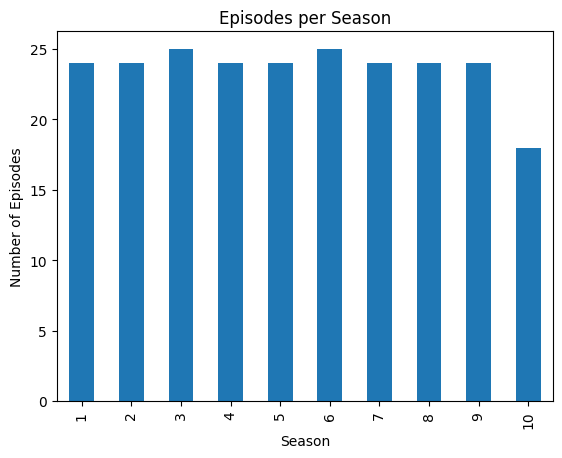

In [20]:
# number of episodes per season
ep_per_season = df_script.groupby("season")["episode"].max()

ep_per_season.plot(kind="bar")

plt.xlabel("Season")
plt.ylabel("Number of Episodes")
plt.title("Episodes per Season")
plt.show();

### Interlude: get rid of "content" column and rows
Based on the column `type` for the rows and the column `content`. These contain commercial breaks, transcription notes, etc.

In [21]:
df_script["content"].unique()[:5]

array([nan, 'Commercial Break', 'Closing Credits', 'End',
       'Opening Credits'], dtype=object)

In [22]:
df_script[df_script["type"] == "content"][:5]

,episode_number,title,writers,type,speaker,dialogue_raw,dialogue_clean,stage_direction_inline,scene_note_inline,stage_direction_only,scene_note_only,content,season,episode
121,S01E01,The One Where Monica Gets a Roommate: The Pilot,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Commercial Break,1,1
189,S01E01,The One Where Monica Gets a Roommate: The Pilot,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Commercial Break,1,1
318,S01E01,The One Where Monica Gets a Roommate: The Pilot,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closing Credits,1,1
338,S01E01,The One Where Monica Gets a Roommate: The Pilot,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,End,1,1
350,S01E02,The One with the Sonogram at the End,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Opening Credits,1,2


In [23]:
print("Before:", df_script.shape)

df_script = df_script.drop("content", axis='columns').copy()
df_script = df_script[df_script["type"] != "content"]

print("After:", df_script.shape)

Before: (70074, 14)
After: (68796, 13)


### "writers"

Writers sometimes had name changes (hyphenated surnames after marriage or new stage names). Along with these adjustments, misspellings were fixed. Missing writer names (for 81 episodes) were also filled in.

In total there were 50 writers, some only working on one episode. The preprocessing below changes each writers cell into a list with all the authors.

For the model, we may need to use `.explode()`.

In [24]:
print(df_script["writers"].dropna().unique().tolist())

['Marta Kauffman & David Crane', 'Jeffrey Astrof & Mike Sikowitz.', 'Alexa Junge', 'Jeff Greenstein & Jeff Strauss', 'Adam Chase & Ira Ungerleider', 'Jeffrey Astrof and Mike Sikowitz.', 'Marta Kaufmann & David Crane', 'Jeffrey Astrof, Mike Sikowitz, Adam Chase & Ira Ungerleider', 'Bill Lawrence', 'Jeffrey Astrof and Mike Sikowitz. .', 'Jeffrey Astrof & Mike Sikowitz', 'Doty Abrams', 'Adam Chase and Ira Ungerleider', 'Chris Brown', 'Jeff Astroff & Mike Sikowitz', 'Ira Ungerlieder.', 'Michael Curtis and Gregory S. Malins', 'Ira Ungerleider', 'Wil Calhoun', 'Scott Silveri & Shana Goldnerg-Meehan.', 'Seth Kurland', 'Adam Chase', 'Michael Borkow', 'Scott Silveri & Shana Goldberg-Meehan', 'Andrew Reich & Ted Cohen', 'Jill Condon & Any Toomin', 'Seth Kirkland', 'Michael Curtis & Gregory S. Malins', 'Scott Silveri', 'Jill Condon & Amy Toomin', 'Shana Goldberg-Meehan', 'Wil Calhoun & Scott Silveri', 'Michael Curtis', 'Perry Rein & Gigi McCreery', 'Greg Malins', 'Alicia Sky Varinaitis', 'Shana G

In [25]:
def clean_writers(name):
    if pd.isna(name) or name == "unknown yet" or name == "":
        return np.nan
    
    name = str(name).strip()
    
    # Replace " & " and " and " with commas
    name = re.sub(r"\s*(&|and)\s*", ",", name, flags=re.IGNORECASE)
    
    # Special case: protect ", Jr." from being split
    name = name.replace(", Jr.", "§Jr.§")
    
    # Remove unnecessary whitespace and ".." or trailing "."
    name = re.sub(r"\s*,\s*", ",", name)
    name = re.sub(r"\.+$", "", name)
    name = re.sub(r"\s*\.+\s*$", "", name)
    
    # Split into list and restore "Jr."
    parts = [n.strip() for n in name.split(",") if n.strip()]
    parts = [p.replace("§Jr.§", ", Jr.") for p in parts]

    return parts

In [26]:
# Dictionary mapping episode numbers to missing writers (74 episodes)
missing_writers_dict = {
    "S01E23": ["Marta Kauffman", "David Crane", "Jeff Greenstein", "Jeff Astrof"],
    "S02E03": ["Michael Curtis", "Greg Malins"],
    "S02E15": ["Michael Curtis", "Greg Malins"],
    "S02E19": ["Michael Curtis", "Greg Malins"],
    "S02E04": ["Alexa Junge"],
    "S02E14": ["Alexa Junge"],
    "S02E22": ["Alexa Junge"],
    "S02E05": ["Chris Brown"],
    "S02E06": ["Betsy Borns"],
    "S02E16": ["Betsy Borns"],
    "S02E07": ["Michael Borkow"],
    "S04E23": ["Michael Borkow"],
    "S04E24": ["Shana Goldberg-Meehan", "Scott Silveri"],
    "S02E08": ["Marta Kauffman", "David Crane"],
    "S02E09": ["Jeff Astrof", "Mike Sikowitz"],
    "S02E11": ["Doty Abrams"],
    "S02E12": ["Jeff Astrof", "Mike Sikowitz", "Michael Borkow"],
    "S02E13": ["Jeff Astrof", "Mike Sikowitz", "Michael Borkow"],
    "S02E17": ["Adam Chase"],
    "S02E18": ["Alexa Junge", "Michael Borkow"],
    "S02E20": ["Adam Chase", "Michael Curtis", "Greg Malins"],
    "S04E20": ["Adam Chase", "Michael Curtis", "Greg Malins"],
    "S02E21": ["Sebastian Jones", "Brian Buckner"],
    "S02E23": ["Brown Mandell"],
    "S02E24": ["Ira Ungerleider", "Brown Mandell"],
    "S03E24": ["Pang-Ni Landrum", "Mark J. Kunerth", "Shana Goldberg-Meehan", "Scott Silveri"],
    "S03E25": ["Pang-Ni Landrum", "Mark J. Kunerth", "Adam Chase"],
    "S04E15": ["Wil Calhoun", "Andrew Reich", "Ted Cohen"],
    "S04E16": ["Shana Goldberg-Meehan", "Scott Silveri", "Alicia Sky Varinaitis"],
    "S04E17": ["Richard Goodman", "Mark J. Kunerth"],
    "S04E18": ["Jill Condon", "Amy Toomin", "Andrew Reich", "Ted Cohen"],
    "S04E22": ["Michael Curtis", "Greg Malins", "Seth Kurland"],
    "S05E11": ["Suzie Villandry", "Brian Boyle"],
    "S05E13": ["Michael Curtis", "Seth Kurland"],
    "S05E16": ["Gigi McCreery", "Perry Rein", "Alicia Sky Varinaitis"],
    "S05E21": ["Greg Malins", "Scott Silveri"],
    "S05E22": ["Wil Calhoun", "Shana Goldberg-Meehan"],
    "S05E23": ["Andrew Reich", "Ted Cohen"],
    "S05E24": ["Greg Malins", "Scott Silveri"],
    "S06E11": ["Brian Boyle", "Zachary Rosenblatt"],
    "S06E12": ["Andrew Reich", "Ted Cohen", "Shana Goldberg-Meehan"],
    "S06E13": ["Seth Kurland", "Sherry Bilsing", "Ellen Plummer"],
    "S06E15": ["Adam Chase", "Greg Malins"],
    "S06E16": ["David Crane", "Marta Kauffman"],
    "S06E17": ["Adam Chase", "Zachary Rosenblatt"],
    "S06E19": ["Gigi McCreery", "Perry Rein", "Seth Kurland"],
    "S06E21": ["Scott Silveri", "David J. Lagana"],
    "S06E22": ["Brian Caldirola", "Sherry Bilsing", "Ellen Plummer"],
    "S06E24": ["Shana Goldberg-Meehan", "Scott Silveri"],
    "S06E25": ["Andrew Reich", "Ted Cohen"],
    "S07E01": ["Marta Kauffman", "David Crane", "Wil Calhoun"],
    "S07E05": ["Patty Lin", "Earl Davis"],
    "S07E13": ["Sebastian Jones", "Brian Buckner", "Sherry Bilsing", "Ellen Plummer"],
    "S07E14": ["Vanessa McCarthy", "Sherry Bilsing", "Ellen Plummer"],
    "S07E15": ["Andrew Reich", "Ted Cohen", "Sherry Bilsing", "Ellen Plummer"],
    "S07E16": ["Zachary Rosenblatt", "Sebastian Jones", "Brian Buckner"],
    "S07E17": ["Sebastian Jones", "Brian Buckner", "Andrew Reich", "Ted Cohen"],
    "S07E18": ["Brian Boyle", "Sherry Bilsing", "Ellen Plummer"],
    "S07E22": ["Sebastian Jones", "Brian Buckner", "Greg Malins"],
    "S07E23": ["Greg Malins"],
    "S07E24": ["Marta Kauffman", "David Crane"],
    "S08E10": ["Sebastian Jones", "Brian Buckner", "Robert Carlock"],
    "S08E17": ["Steven Rosenhaus", "R. Lee Fleming, Jr."],
    "S08E18": ["Mark J. Kunerth", "Peter Tibbals"],
    "S08E21": ["Sebastian Jones", "Brian Buckner", "Dana Klein Borkow"],
    "S08E23": ["Scott Silveri"],
    "S08E24": ["Marta Kauffman", "David Crane"],
    "S09E08": ["Shana Goldberg-Meehan"],
    "S09E09": ["Mark J. Kunerth"],
    "S09E11": ["Peter Tibbals", "Judd Rubin"],
    "S09E12": ["Sebastian Jones", "Brian Buckner", "Dana Klein Borkow"],
    "S09E15": ["Peter Tibbals"],
    "S09E16": ["Mark J. Kunerth"],
    "S09E17": ["Sebastian Jones", "Brian Buckner", "Robert Carlock"],
    "S09E18": ["Sebastian Jones", "Brian Buckner", "Sherry Bilsing", "Ellen Plummer"],
    "S09E19": ["Mark J. Kunerth", "Dana Klein Borkow"],
    "S09E20": ["Andrew Reich", "Ted Cohen", "Shana Goldberg-Meehan"],
    "S09E21": ["Scott Silveri", "Robert Carlock"],
    "S09E23": ["Scott Silveri", "Shana Goldberg-Meehan"],
    "S09E24": ["Marta Kauffman", "David Crane"],
    "S10E14": ["Robert Carlock", "Tracy Reilly"]
}

# Function that looks up the episode number
def missing_writers(name, number):
    return missing_writers_dict.get(number, name)

In [27]:
# Dictionary mapping wrong names to correct names (misspelling and stage names)
name_corrections = {
    "Jeffrey Astrof": "Jeff Astrof",
    "Jeff Astroff": "Jeff Astrof",
    "Marta Kaufmann": "Marta Kauffman",
    "Ira Ungerlieder": "Ira Ungerleider",
    "Shana Goldnerg-Meehan": "Shana Goldberg-Meehan",
    "Any Toomin": "Amy Toomin",
    "Sherry Bilsing-Graham": "Sherry Bilsing",
    "Sherry Bilding-Graham": "Sherry Bilsing",
    "Gigi McCreey": "Gigi McCreery",
    "Gregory S. Malins": "Greg Malins",
    "Zack Rosenblatt": "Zachary Rosenblatt",
    "Dana Klein": "Dana Klein Borkow",
    "Mark Kunerth": "Mark J. Kunerth",
    "Seth Kurl": "Seth Kurland",
    "Seth Kirkl": "Seth Kurland",
    "rew Reich": "Andrew Reich"
}

def name_correction(name, corrections):    
    for index, n in enumerate(name):
        if n in corrections:
            name[index] = corrections[n]
    return name

In [28]:
# clean stray punctuation and formatting
df2 = df_script.copy()
df2["writers"] = df2["writers"].apply(clean_writers)

In [29]:
# fill in missing writers rows
print("There are", len(set(df2[df2["writers"].isnull()]["episode_number"])), "episodes missing writers' names.")
df2['writers'] = df2.apply(lambda row: missing_writers(row['writers'], row['episode_number']), axis=1)

There are 81 episodes missing writers' names.


In [30]:
# correct writer name misspellings and stage names
df2["writers"] = df2["writers"].apply(lambda x: name_correction(x, name_corrections))

In [31]:
## For viewing all writers
# Flatten the lists in the column into rows
all_writers = df2["writers"].explode()

unique_writers = all_writers.dropna().unique()

print(unique_writers)
print("\nThere were", len(unique_writers), "writers for the FRIENDS series. IMDB states that there were 50 writers in total.")

['Marta Kauffman' 'David Crane' 'Jeff Astrof' 'Mike Sikowitz'
 'Alexa Junge' 'Jeff Greenstein' 'Jeff Strauss' 'Adam Chase'
 'Ira Ungerleider' 'Bill Lawrence' 'Doty Abrams' 'Chris Brown'
 'Michael Curtis' 'Greg Malins' 'Betsy Borns' 'Michael Borkow'
 'Sebastian Jones' 'Brian Buckner' 'Brown Mandell' 'Wil Calhoun'
 'Scott Silveri' 'Shana Goldberg-Meehan' 'Seth Kurland' 'Andrew Reich'
 'Ted Cohen' 'Pang-Ni Landrum' 'Mark J. Kunerth' 'Jill Condon'
 'Amy Toomin' 'Alicia Sky Varinaitis' 'Richard Goodman' 'Perry Rein'
 'Gigi McCreery' 'Suzie Villandry' 'Brian Boyle' 'Sherry Bilsing'
 'Ellen Plummer' 'Zachary Rosenblatt' 'David J. Lagana' 'Brian Caldirola'
 'Patty Lin' 'Earl Davis' 'Vanessa McCarthy' 'Dana Klein Borkow'
 'R. Lee Fleming, Jr.' 'Robert Carlock' 'Steven Rosenhaus' 'Peter Tibbals'
 'Judd Rubin' 'Tracy Reilly']

There were 50 writers for the FRIENDS series. IMDB states that there were 50 writers in total.


In [32]:
df_script["writers"] = df2["writers"].copy()

### Interlude: get rid of voiceover lines and writer introductions

Remove voiceover rows and rows that introduce the backstage crew (speaker is part 1 or 2 written by, dialogue shows names).

In [33]:
# remove voiceovers
df_script = df_script[~df_script["dialogue_clean"].str.contains("Previously on Friends", na=False)].copy()

In [34]:
# make everything upper case
df_script["speaker"] = df_script["speaker"].str.upper()

# remove everything with "by" since it's not a speaking turn
df_script = df_script[~df_script["speaker"].str.contains(" BY", na=False)].copy()

In [35]:
df_script.shape

(68684, 13)

### "type"
"content" rows have been dropped. We could take a look at the other two aside from "dialogue".

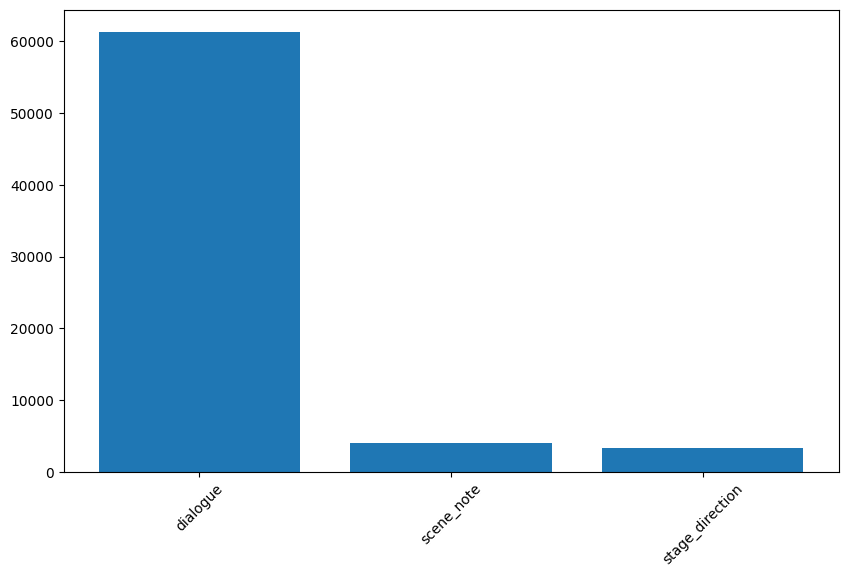

In [36]:
# types of lines without content
counts = df_script["type"].value_counts().head(20)

plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45);

In [37]:
df_script[df_script["type"] == "scene_note"]["scene_note_only"].head(10)

0      Scene: Central Perk, Chandler, Joey, Phoebe, a...
9                                             Time Lapse
20                         Time Lapse, Ross has entered.
74      Time Lapse, Rachel is breating into a paper bag.
122     Scene: The Subway, Phoebe is singing for change.
124    Scene: Ross's Apartment, the guys are there as...
144     Scene: A Restaurant, Monica and Paul are eating.
155    Scene: Ross's Apartment; Ross is pacing while ...
179    Scene: Monica's Apartment, Rachel is watching ...
182    Scene: Ross's Apartment, they're all sitting a...
Name: scene_note_only, dtype: object

In [38]:
df_script[df_script["type"] == "stage_direction"]["stage_direction_only"].head(10)

5                               They all stare, bemused.
43                            Ross gestures his consent.
46     Rachel enters in a wet wedding dress and start...
54     They go to hug but Ross's umbrella opens.  He ...
63     The scene on TV has changed to show two women,...
68     She is pushed down the stairs and everyone che...
83          The door buzzer sounds and Chandler gets it.
100           There's a knock on the door and it's Paul.
108                               Monica goes to change.
126    Joey and Chandler are finishing assembling the...
Name: stage_direction_only, dtype: object

### "speaker"

Some "speaker" values come with stage directions (AMY COMING OUT OF THE BATHROOM; JOEY (TO ROSS)) or include multiple speakers (PHOEBE, ROSS, CHANDLER, AND JOEY). Some are also unnamed characters (AIR STEWARDESS, PASSENGER #2). Some are nicknames (RACH for RACHEL).

The first needs to move to `stage_direction_inline`. The second and third can be left as is. The fourth will manually be changed.

In [39]:
print(df_script["speaker"].dropna().unique())

['MONICA' 'JOEY' 'CHANDLER' 'PHOEBE' 'ALL' 'ROSS' 'RACHEL' 'WAITRESS'
 'PHOEBE, ROSS, CHANDLER, AND JOEY' 'PAUL' 'PRIEST ON TV' 'FRANNIE'
 'ROSS AND RACHEL' 'CUSTOMER' 'MARSHA' 'CAROL' 'CHANDLER AND JOEY'
 'MRS. GELLER' 'MR. GELLER' 'SUSAN' 'BARRY' 'ROBBIE' 'BERNICE'
 'DR. OBERMAN' 'PAULA' 'ALAN' 'THE GUYS' 'LIZZIE' 'GUYS' 'LESLIE' 'KIKI'
 'JOANNE' 'RECEPTIONIST' 'PIZZA GUY' 'MONICA AND PHOEBE' 'BOTH' 'KID'
 'ANGELA' 'JANICE' 'WOMAN' 'BOB' 'AURORA' 'DIRECTOR' 'JILL'
 'MONICA, JOEY, AND PHOEBE' 'MR. HECKLES' 'PAOLO' 'SHELLEY' 'AUNT LILLIAN'
 'NURSE' 'ANDREA' 'LOWELL' 'TERRY' 'GUY' 'GIRL' 'MAX' 'DAVID' 'SANDY'
 'FUN BOBBY' 'DICK CLARK' 'JAY LENO' 'MRS. BING' 'COMA GUY'
 'JOEY, CHANDLER, AND ROSS' 'CAROL AND SUSAN' "PHOEBE'S ASSISTANT"
 'JOEY AND CHANDLER' 'RACHEL AND PHOEBE' 'GIRLS' 'ROGER' 'MR. TRIBBIANI'
 'RONNI' 'MRS. TRIBBIANI' 'LORRAINE' 'KRISTIN' 'FIREMAN NO. 1'
 'FIREMAN NO. 2' 'FIREMAN NO. 3' 'MRS. TEDLOCK' 'CELIA' 'STEVE' 'URSULA'
 'TEACHER' 'HELEN' 'NINA' 'ROSS AND SUSAN' 'MR. 

First we remove some mislabelled rows. Then we start preprocessing and correcting the `speaker` names.

In [40]:
# fix random speaker = SCENE line
mask = df_script["speaker"] == "CREDITS [SCENE"
temp_cols = ["speaker", "scene_note_only", "type", "dialogue_raw", "dialogue_clean"]

df_script.loc[mask, temp_cols] = [
    np.nan,
    "Scene: Central Perk, Russ enters, Chandler and Phoebe are sitting on the couch.",
    "scene_note",
    np.nan,
    np.nan
]

In [41]:
# fix random speaker = CUT TO line
mask2 = df_script["speaker"] == "CUT TO"

df_script.loc[mask2, temp_cols] = [
    np.nan,
    "Scene: Monica and Chandler's apartment.",
    "scene_note",
    np.nan,
    np.nan
]

In [42]:
# drop wrong row with writer's note
df_script = df_script[~(df_script["speaker"] == "NOTE")].copy()

In [43]:
df3 = df_script.copy()
pattern = re.compile(r"^(.*?)\s*(?:[\(\[](.*?)[\)\]])?$")

# Extract name and extra info
df3[["speaker", 'stage_direction_inline']] = df3["speaker"].str.extract(pattern)

In [44]:
# fix few random speakers with actions
subset_lines = [
    'JOEY NODS',
    'RACHEL TO EMMA',
    'WOMAN AT DOOR',
    'ROSS AND RACHEL WHILE LOOKING AT EACH OTHER SURPRISED AND SHOCKED',
    'WOMAN AT DOOR IN A SING SONG VOICE',
    'ROSS WITH A LOOK OF WONDERING HOW LONG THIS IS GOING TO GO ON ON HIS FACE',
    "ROSS STARTS TALKING OVER HER 'DO YOU REMEMBER' LINE",
    'AMY WITH STRAIGHT HAIR',
    'AMY STORMS OUT',
    'RACHEL OPENS THEIR DOOR',
    'JOEY LAUGHS',
    'JOEY LOOKS REJECTED',
    'ROSS TO MONICA',
    'MONICA TO ROSS',
    'MONICA TO EMMA',
    'MONICA TO AMY',
    'AMY WITH CONFUSED LOOK ON FACE',
    'PHOEBE SHAKES HER HAND AND SAYS',
    'PHOEBE LOOKS DOWN',
    'AMY COMING OUT OF THE BATHROOM',
    "ROSS FIRST HAS A LOOK OF 'HUH' THEN CHANGES IT TO SARCASTIC HAPPY",
    'AMY TURNS AROUND TO PHOEBE',
    'AMY TURNS TO ROSS AND RACHEL',
    'ROSS STARTS PLAYING WITH A PLATE',
    'MONICA ABOUT TO HAVE A HEART ATTACK',
    'JOEY RAISES HIS HAND',
    'ROSS LOOKS DOWN',
    'PHOEBE WHILE CUTTING A SWEET POTATOE IN THE AIR',
    'JOEY GROANS AND GETS OFF THE PHONE',
    'JOEY ALL NERVOUS AND LOOKING DOWN AND FIDDLING WITH HIS EAR',
    'AMY WALKS OVER TO THE COUCH AND SITS DOWN NEXT TO RACHEL',
    'RACHEL TURNS TO ROSS',
    'ROSS WALKS OVER',
    'MONICA SCREAMING AT ROSS',
    "RACHEL STARTS MESSING UP AMY'S HAIR",
    'MONICA STARTS CRYING',
    'AMY STARTING TO CRY'
]

pattern2 = re.compile(r"^([A-Z]+(?: (?:AND|AT) [A-Z]+)*)\s*(.*)$")
mask3 = df3['speaker'].isin(subset_lines)

# Apply regex only on the subset of lines
df3.loc[mask3, ['speaker', 'stage_direction_inline']] = df3.loc[mask3, 'speaker'].str.extract(pattern2)

In [45]:
speaker_corrections = {
    "CHAN": "CHANDLER",
    "RACH": "RACHEL",
    "RACEL": "RACHEL",
    "RAHCEL": "RACHEL",
    "RAHCEL": "RACHEL",
    "PHOE": "PHOEBE",
    "MNCA": "MONICA",
    "MONA": "MONICA",
    "MICH": "MICHAEL",
    "PHOE/MNCA": "PHOEBE, MONICA",
    "RTST": "MR. RASTATTER",
    "JOEY/CHAN": "JOEY, CHANDLER",
    "CHAN, JOEY, ROSS": "CHANDLER, JOEY, ROSS",
    "GANG": "ALL",
    "FBOB": "FUN BOBBY",
    "ESTL": "ESTELLE",
    "DR. REMORE": "DR. RAMORAY",
    "DR. DRAKE REMORAY": "DR. RAMORAY",
    "DR. DRAKE RAMORAY": "DR. RAMORAY",
    "DR HORTON": "DR. HORTON",
    "AMGER": "AMBER",
    "EVERYONE": "ALL",
    "DR GREEN": "DR. GREEN",
    "SHERMAN WHITFIELD": "WHITFIELD",
    "MATRESS KING": "MATTRESS KING",
    "BILLY CRYSTAL": "BILLY",
    "ELIZABETH HORNSWOGGLE": "ELIZABETH",
    "DR. TIMOTHY BURKE": "TIM",
    "EVERYONE ALMOST SIMULTANEOUSLY EXCEPT ROSS": "ALL",
    "SANDY/GRUMPUS": "SANDY",
    "JOEY/WIGGLEMUNCH": "JOEY",
    "EVERYONE BUT MONICA": "ALL",
    "EVERYONE THERE SAYS": "ALL",
    "EVERYBODY": "ALL",
    "RACHEL/ACTRESS": "RACHEL",
    "RACHEL/ROSS": "RACHEL, ROSS",
    "PROFESSOR SHERMAN": "PROF. SHERMAN",
    "AMY AND RACHEL AT SAME TIME": "RACHEL, AMY",
    "JOEY'S VOICE, BUT SHE SEES ROSS": "JOEY, ROSS",
    "JOEY'S VOICE/ROSS": "JOEY, ROSS",
    "AGENCY GUY": "ADOPTION AGENCY GUY",
    "DONNY OSMOND": "DONNY",
    "PHOEBE SR": "PHOEBE SR.",
    "MAITRE D�": "MAITRE D'",
    "MATIRE'D": "MAITRE D'",
    "JOEY/DRAKE": "JOEY",
    "ACTRESS/OLIVIA": "OLIVIA",
    "GUYS": "THE GUYS"
}

# use cleaning func from before
df3["speaker"] = df3["speaker"].replace(speaker_corrections)

# change " AND " or " & " to ", "
df3["speaker"] = df3["speaker"].str.replace(r"\W\s+AND\s+| \& |\/", ", ", regex=True)
df3["speaker"] = df3["speaker"].str.replace(r"\s+AND\s+", ", ", regex=True)

In [46]:
print(df3["speaker"].dropna().unique())

['MONICA' 'JOEY' 'CHANDLER' 'PHOEBE' 'ALL' 'ROSS' 'RACHEL' 'WAITRESS'
 'PHOEBE, ROSS, CHANDLER, JOEY' 'PAUL' 'PRIEST ON TV' 'FRANNIE'
 'ROSS, RACHEL' 'CUSTOMER' 'MARSHA' 'CAROL' 'CHANDLER, JOEY' 'MRS. GELLER'
 'MR. GELLER' 'SUSAN' 'BARRY' 'ROBBIE' 'BERNICE' 'DR. OBERMAN' 'PAULA'
 'ALAN' 'THE GUYS' 'LIZZIE' 'LESLIE' 'KIKI' 'JOANNE' 'RECEPTIONIST'
 'PIZZA GUY' 'MONICA, PHOEBE' 'BOTH' 'KID' 'ANGELA' 'JANICE' 'WOMAN' 'BOB'
 'AURORA' 'DIRECTOR' 'JILL' 'MONICA, JOEY, PHOEBE' 'MR. HECKLES' 'PAOLO'
 'SHELLEY' 'AUNT LILLIAN' 'NURSE' 'ANDREA' 'LOWELL' 'TERRY' 'GUY' 'GIRL'
 'MAX' 'DAVID' 'SANDY' 'FUN BOBBY' 'DICK CLARK' 'JAY LENO' 'MRS. BING'
 'COMA GUY' 'JOEY, CHANDLER, ROSS' 'CAROL, SUSAN' "PHOEBE'S ASSISTANT"
 'JOEY, CHANDLER' 'RACHEL, PHOEBE' 'GIRLS' 'ROGER' 'MR. TRIBBIANI' 'RONNI'
 'MRS. TRIBBIANI' 'LORRAINE' 'KRISTIN' 'FIREMAN NO. 1' 'FIREMAN NO. 2'
 'FIREMAN NO. 3' 'MRS. TEDLOCK' 'CELIA' 'STEVE' 'URSULA' 'TEACHER' 'HELEN'
 'NINA' 'ROSS, SUSAN' 'MR. DOUGLAS' 'JAMIE' 'FRAN' 'RACHEL, CHANDLER

In [62]:
df_script["speaker"] = df3["speaker"].copy()

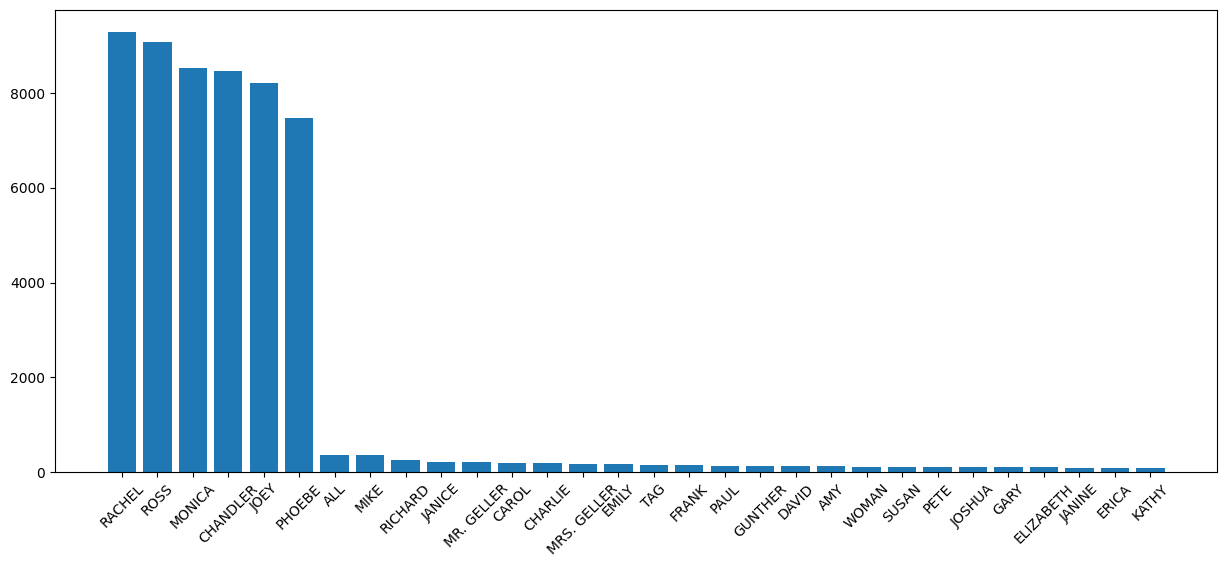

In [65]:
# Count each speaker
counts = df_script["speaker"].value_counts().head(30)

plt.figure(figsize=(15,6))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45);

This does not preprocess "BOTH" or multiple names in different orders.

### "dialogue_raw"

### "dialogue_clean"

### "stage_direction_inline"
Helps to convey emotion. Some of them seem to be written by the speaker's name in the `speaker` column instead of in this column.

In [49]:
print("Missingness percentage:", df_script["stage_direction_inline"].isnull().sum(axis = 0) / df_script.shape[0], "\n")
print(df_script["stage_direction_inline"].dropna().unique()[:50])

Missingness percentage: 0.807972860824367 

['(mortified)' '(explaining to the others)' '(to Ross)'
 '(She starts to pluck at the air just in front of Ross.)'
 '(They all stare at him.)' '(He extends his hand hopefully.)'
 '(pointing at Rachel) | (to All) | (to Rachel)'
 '(to the waitress that brought her coffee) | (to Monica)'
 '(imitating the characters)' '(in a deep voice)' '(on phone)' '(re TV)'
 '(sings) | (Rachel and Monica turn to look at her.)'
 '(grins and walks to the kitchen and says to Chandler and Joey.)'
 '(comforting her)' '(over the intercom)' '(choked voice)' '(horrified)'
 '(normal voice)' "(Chandler doesn't know.)"
 '(They are all lined up next to the door.)' '(Shows Paul in)'
 '(yelling from the bedroom)' '(thinks)' '(deadpan)'
 '(singing) | (some guy gives her some change and to that guy) | (sings)'
 '(squatting and reading the instructions)' '(picking up a leftover part)'
 '(clutching a beer can and sniffing)' '(laughing)'
 '(She stops talking and dials the phone.

### "scene_note_inline"
Not sure how to use these. Could be interesting when combined with "scene_note" in the `type` column. Don't know how this is different / better compared to `scene_note_only`.

In [50]:
print("Missingness percentage:", df_script["scene_note_inline"].isnull().sum(axis = 0) / df_script.shape[0], "\n")
print(df_script["scene_note_inline"].dropna().unique()[:50])

Missingness percentage: 0.9915699663672233 

["Scene: Monica's Apartment, everyone is there and watching a Spanish Soap on TV and are trying to figure out what is going on."
 "Scene: Monica's Apartment, Rachel is talking on the phone and pacing."
 'Scene: A Restaurant, Monica and Paul are still eating.'
 'a pigeon flies in the window and lands on the table | hangs up | grabs a pot and lid | puts pot over the pigeon | knock at the door'
 'leaves flowers on bar'
 'in surprise she forgets she has the pigeon in the pot and lets it get away'
 "turns to Chandler who's looking sheepish" 'to Chandler'
 'to Monica at the counter'
 "holding cream pitcher | holds pitcher in front of Chandler's chest and flips the lid"
 'Julie leaves' 'Rachel struts off, extremely pleased with herself'
 'they hug' 'Duncan leaves' 'hands her a bowl and kisses her'
 'pulls Rachel aside' 'Chandler puts the tape in' 'Joey from TV'
 'Rachel gives her a look from hell' 'handing him the papers'
 'they hug and kiss' 'bein

### "stage_direction_only"
Also don't know what to do with this.

In [51]:
print("Missingness percentage:", df_script["stage_direction_only"].isnull().sum(axis = 0) / df_script.shape[0], "\n")
print(df_script["stage_direction_only"].dropna().unique()[:50])

Missingness percentage: 0.9516765429582283 

['They all stare, bemused.' 'Ross gestures his consent.'
 'Rachel enters in a wet wedding dress and starts to search the room.'
 "They go to hug but Ross's umbrella opens.  He sits back down defeated again.  A moment of silence follows as Rachel sits and the others expect her to explain."
 'The scene on TV has changed to show two women, one is holding her hair.'
 'She is pushed down the stairs and everyone cheers.'
 'The door buzzer sounds and Chandler gets it.'
 "There's a knock on the door and it's Paul." 'Monica goes to change.'
 'Joey and Chandler are finishing assembling the bookcase.'
 'Joey checks that Ross is not looking and dumps it in a plant.'
 "Monica and Paul walk to the door and talk in a low voice so the others can't hear.  The others move Monica's table closer to the door so that they can."
 'Monica exits.'
 'Monica pushes him off of the sofa as Rachel enters with a shopping bag.'
 'Pause' 'She finishes cutting them up and th

### "scene_note_only"
Can be used as an additional attribute to see if the audience prefers certain locations. #TODO: create frequencies of most visited places and add to `rating` dataframe.

In [52]:
print("Missingness percentage:", df_script["scene_note_only"].isnull().sum(axis = 0) / df_script.shape[0], "\n")
print(df_script["scene_note_only"].dropna().unique()[:50])

Missingness percentage: 0.941237278511422 

['Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.'
 'Time Lapse' 'Time Lapse, Ross has entered.'
 'Time Lapse, Rachel is breating into a paper bag.'
 'Scene: The Subway, Phoebe is singing for change.'
 "Scene: Ross's Apartment, the guys are there assembling furniture."
 'Scene: A Restaurant, Monica and Paul are eating.'
 "Scene: Ross's Apartment; Ross is pacing while Joey and Chandler are working on some more furniture."
 "Scene: Monica's Apartment, Rachel is watching Joanne Loves Chaci."
 "Scene: Ross's Apartment, they're all sitting around and talking."
 'Cut to Rachel staring out of her window.'
 "Scene: Monica's Apartment, Rachel is making coffee for Joey and Chandler."
 'Scene: Iridium, Monica is working as Frannie enters.'
 'Scene: Central Perk, everyone but Rachel is there.'
 "Scene: Monica and Rachel's, everyone is sitting around the kitchen table.   Rachel's credit cards are spread out on the table along with a pai

---

## Ratings Dataset EDA

The dataset is from Kaggle, made by users Mohammad Reza Ghari and Moulik Dhade, accessible [here](https://www.kaggle.com/datasets/rezaghari/friends-series-dataset/data). It contains the IMDB ratings of each episode of FRIENDS, along with how many votes there were.

In [53]:
df_rating.columns

Index(['Year_of_prod', 'Season', 'Episode Number', 'Episode_Title', 'Duration',
       'Summary', 'Director', 'Stars', 'Votes'],
      dtype='object')

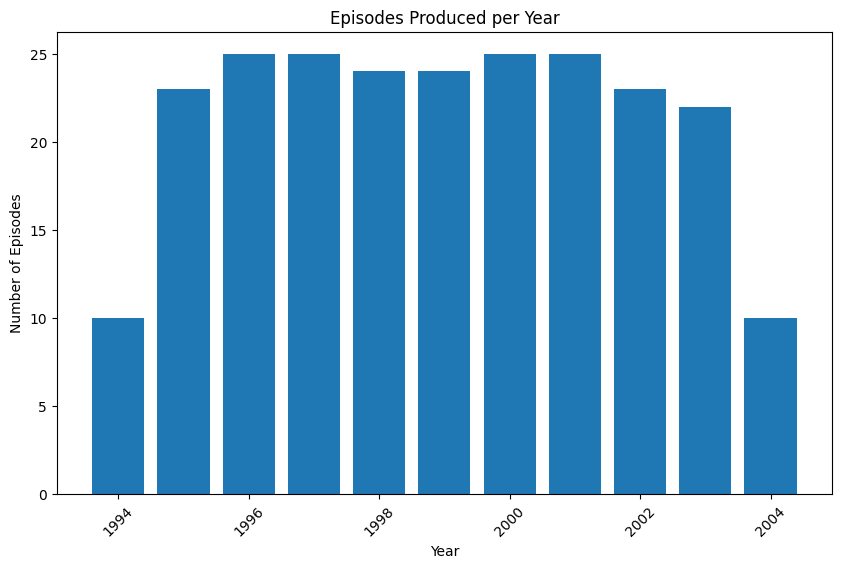

In [54]:
# number of episodes released per year
counts2 = df_rating["Year_of_prod"].value_counts().head(20)

plt.figure(figsize=(10,6))
plt.bar(counts2.index, counts2.values)
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Number of Episodes")
plt.title("Episodes Produced per Year")
plt.show();

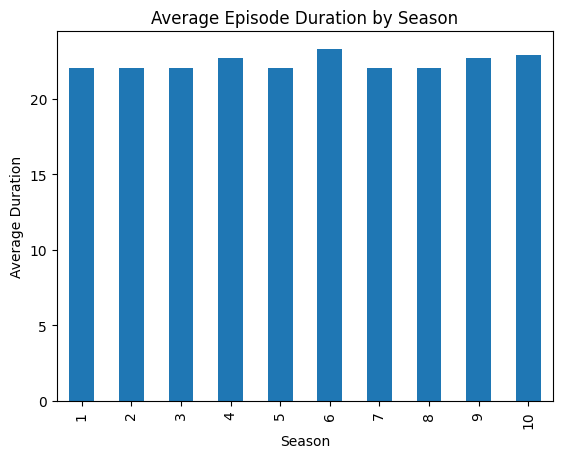

In [55]:
# avg episode duration by season
avg_duration = df_rating.groupby("Season")["Duration"].mean()

avg_duration.plot(kind="bar")

plt.xlabel("Season")
plt.ylabel("Average Duration")
plt.title("Average Episode Duration by Season")
plt.show();

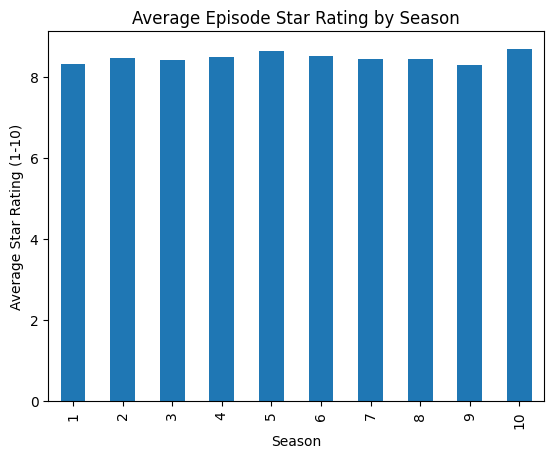

In [56]:
# avg star rating by season
avg_rating = df_rating.groupby("Season")["Stars"].mean()

avg_rating.plot(kind="bar")

plt.xlabel("Season")
plt.ylabel("Average Star Rating (1-10)")
plt.title("Average Episode Star Rating by Season")
plt.show();

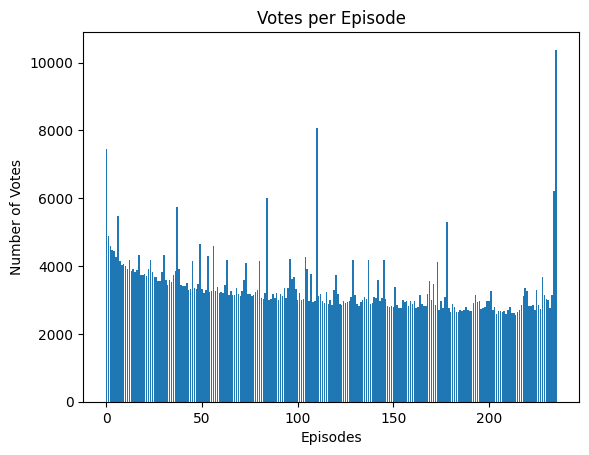

In [57]:
plt.bar(df_rating.index, df_rating["Votes"])
plt.xlabel("Episodes")
plt.ylabel("Number of Votes")
plt.title("Votes per Episode")
plt.show();

In [58]:
# top 5 most voted on episodes
df_rating.sort_values("Votes", ascending=False).head(5)

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes
235,2004,10,18,The Last One: Part 2,30,Phoebe races Ross to the airport in a bid to s...,Kevin Bright,9.7,10381
110,1999,5,14,The One Where Everybody Finds Out,22,When Phoebe finds out about Monica and Chandle...,Michael Lembeck,9.7,8066
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,22,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,7440
234,2004,10,17,The Last One: Part 1,30,Erica gives birth to the baby that Monica and ...,Kevin Bright,9.5,6221
84,1998,4,12,The One with the Embryos,22,Phoebe's uterus is examined for implantation o...,Kevin Bright,9.5,6006


In [59]:
# top 5 least voted on episodes
df_rating.sort_values("Votes", ascending=False).tail(5)

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes
212,2003,9,19,The One with Rachel's Dream,22,Joey is insecure now his Days of Our Lives cha...,Terry Hughes,8.1,2616
213,2003,9,20,The One with the Soap Opera Party,22,Joey throws a cast party on the roof of his bu...,Sheldon Epps,8.2,2615
204,2003,9,11,The One Where Rachel Goes Back to Work,22,Chandler starts looking for a job and is anxio...,Gary Halvorson,8.0,2601
209,2003,9,16,The One with the Boob Job,27,When Monica and Chandler both ask Joey for mon...,Gary Halvorson,8.2,2588
214,2003,9,21,The One with the Fertility Test,22,"Still unable to conceive, Monica and Chandler ...",Gary Halvorson,8.2,2557


In [60]:
# top 10 highest rated episodes
df_rating.sort_values("Stars", ascending=False).head(10)

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes
235,2004,10,18,The Last One: Part 2,30,Phoebe races Ross to the airport in a bid to s...,Kevin Bright,9.7,10381
110,1999,5,14,The One Where Everybody Finds Out,22,When Phoebe finds out about Monica and Chandle...,Michael Lembeck,9.7,8066
234,2004,10,17,The Last One: Part 1,30,Erica gives birth to the baby that Monica and ...,Kevin Bright,9.5,6221
84,1998,4,12,The One with the Embryos,22,Phoebe's uterus is examined for implantation o...,Kevin Bright,9.5,6006
37,1996,2,14,The One with the Prom Video,22,The gang watches a home video from the night o...,James Burrows,9.4,5736
178,2001,8,9,The One with the Rumor,22,"Monica invites Will, an old school friend of h...",Gary Halvorson,9.3,5291
145,2000,6,25,The One with the Proposal,30,Chandler continues to pretend to hate the idea...,Kevin Bright,9.3,4186
173,2001,8,4,The One with the Videotape,22,Ross and Rachel tell everyone about the night ...,Kevin Bright,9.3,4114
96,1998,4,24,The One with Ross's Wedding,30,Phoebe tries to warn the gang that Rachel is c...,Kevin Bright,9.2,4217
169,2001,7,24,The One with Monica and Chandler's Wedding: Pa...,22,Ross tries to find Chandler with Phoebe's help...,Kevin Bright,9.2,3563


In [61]:
# top 10 lowest rated episodes
df_rating.sort_values("Stars", ascending=False).tail(10)

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes
19,1995,1,20,The One with the Evil Orthodontist,22,"Rachel and Barry start dating again, despite t...",Peter Bonerz,7.9,3736
20,1995,1,21,The One with the Fake Monica,22,Monica befriends the woman who stole her credi...,Gail Mancuso,7.9,3769
176,2001,8,7,The One with the Stain,22,"Chandler hires a maid, whom Monica suspects is...",Kevin Bright,7.9,2766
81,1997,4,9,The One Where They're Going to Party!,22,Monica ends up having to choose between a head...,Peter Bonerz,7.9,3045
215,2003,9,22,The One with the Donor,22,When Joey hears that his girlfriend Charlie is...,Ben Weiss,7.8,2635
188,2002,8,19,The One with Joey's Interview,22,Joey prepares for his epic interview with Soap...,Gary Halvorson,7.5,2804
203,2002,9,10,The One with Christmas in Tulsa,22,"Chandler must spend Christmas in Tulsa, which ...",Kevin Bright,7.5,2804
166,2001,7,21,The One with the Vows,22,Monica and Chandler are getting married in fou...,Gary Halvorson,7.5,2832
140,2000,6,20,The One with Mac and C.H.E.E.S.E.,22,Chandler forgets to write down a message for J...,Kevin Bright,7.4,3096
93,1998,4,21,The One with the Invitation,22,As Ross and Emily send out wedding invitations...,Peter Bonerz,7.2,3364
